# **LDA Analysis**

In [ ]:
## Installing necessasry python libraries
!pip install spectral

## Importing basic libraries
import numpy as np
import pandas as pd
import spectral
import time 
import os

## Importing libraries for preprocessing

# To load Hyperspectral image cube .mat file as input
import scipy
from scipy.io import loadmat

# To split training and testing data
import sklearn as sk
from sklearn.model_selection import train_test_split

## Importing libraries for dimensionaltiy reduction 

# Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## Importing libraries for plotting 
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# **Importing Dataset**

### Download dataset

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

--2020-11-11 03:33:15--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat.1’

Indian_pines_correc 100%[===================>]   5.68M   340KB/s    in 20s     

2020-11-11 03:33:35 (293 KB/s) - ‘Indian_pines_corrected.mat.1’ saved [5953527/5953527]

--2020-11-11 03:33:35--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat.1’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2020-11-11 03:33:36 (146 MB/s) - ‘Indian_pines_gt.mat.1’ saved [1125/1125]

FINISHED --2020-11-11 03:33:36--
Total wall clock time: 21s
Downl

### Verifying downloaded data

In [ ]:
!ls

Dataset.csv		    Indian_pines_corrected.mat.1  Indian_pines_gt.mat.1
Indian_pines_corrected.mat  Indian_pines_gt.mat		  sample_data


### Loading Datasets

In [ ]:
def load_dataset():
  
  # X is the input dataset
  X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  
  # y is the labelled dataset
  y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

  # Print shape of input dataset (X) and labelled dataset (y)
  print(f"X shape : {X.shape}\ny shape : {y.shape}")
  
  return X,y

X,y= load_dataset()

X shape : (145, 145, 200)
y shape : (145, 145)


## Visualizing dataset

### Visualizing different bands of input dataset (X)

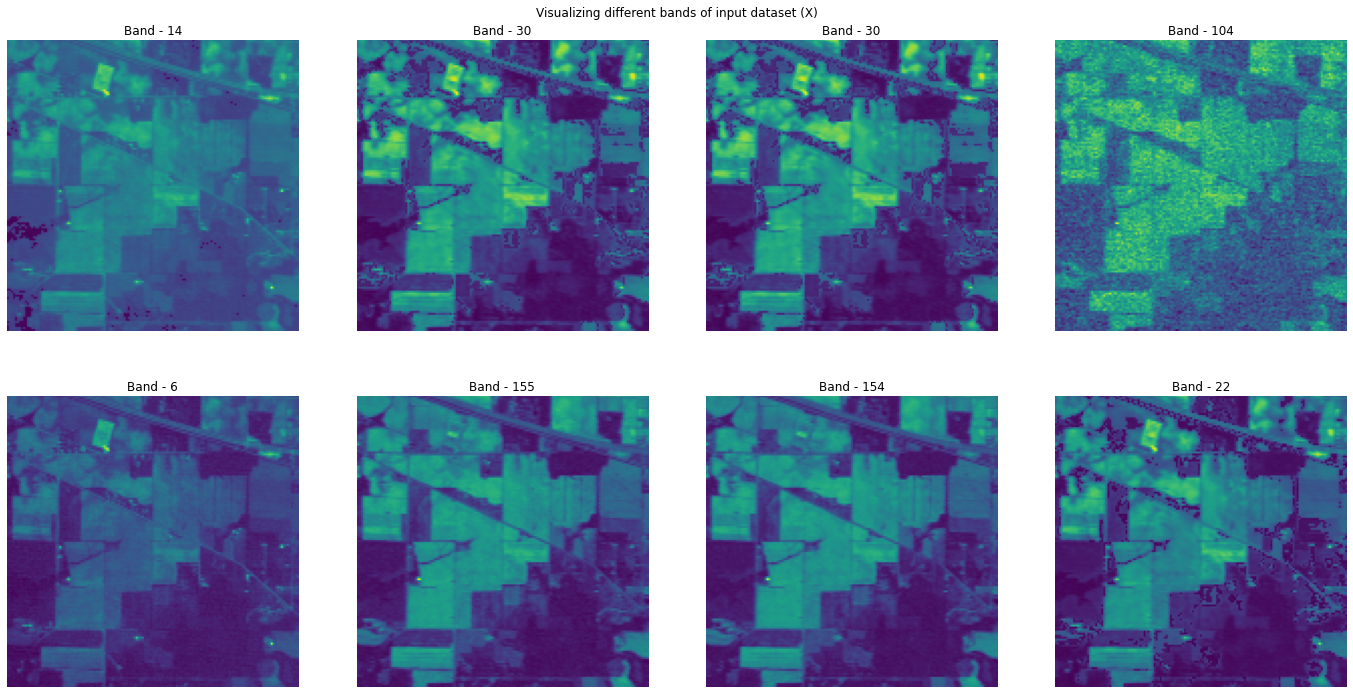

In [ ]:
def visualize_X(X):

  # Plot figure of size (24,12)
  fig = plt.figure(figsize=(24,12))
  fig.set_facecolor("white")
  plt.title("Visualizing different bands of input dataset (X)\n")
  plt.axis('off')
  
  for i in range(1,8+1):
  
    # Creating subplots of randomly selected 8 bands
    fig.add_subplot(2,4,i)
    
    # Generating a random band number 
    n = np.random.randint(X.shape[2])
  
    # Plotting image of random number n band 
    plt.imshow(X[:,:,n])
    plt.axis("off")
    plt.title(f'Band - {n}')

visualize_X(X)

## Visualizing ground truth dataset (y)

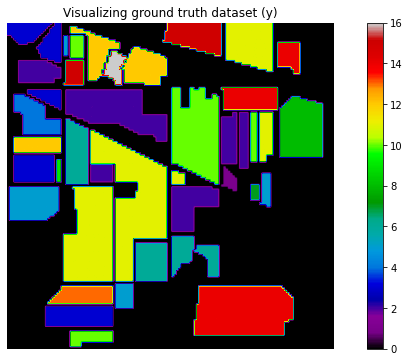

In [ ]:
def visualize_y(y):

  plt.figure(figsize=(12,6)).set_facecolor("white")
  plt.imshow(y, cmap='nipy_spectral')
  plt.title("Visualizing ground truth dataset (y)")
  plt.colorbar()
  plt.axis('off')
  plt.show()

visualize_y(y)

## Convert data into pandas data frame and csv file

In [ ]:
def extract_pixels(X,y):
  
  # input_data_set is a list of all pixel location's band values  
  input_data_set = X.reshape(-1,X.shape[2])
  
  # Convert input_data_set into a panda data frame df
  df = pd.DataFrame(data = input_data_set)
  
  # Concatenate labelled data along with input data into a single data frame df
  df = pd.concat([df,pd.DataFrame(data=y.ravel())],axis=1)

  # Name columns
  df.columns = [f'band{i}' for i in range(1,1+X.shape[2])]+['class']

  # Convert pandas data frame to csv file
  df.to_csv("Dataset.csv")

  return df

df = extract_pixels(X,y)

# Shape of df
print(f"Shape of df : {df.shape}")

# Prints df dataset
df

Shape of df : (21025, 201)


,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,band17,band18,band19,band20,band21,band22,band23,band24,band25,band26,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36,band37,band38,band39,band40,...,band162,band163,band164,band165,band166,band167,band168,band169,band170,band171,band172,band173,band174,band175,band176,band177,band178,band179,band180,band181,band182,band183,band184,band185,band186,band187,band188,band189,band190,band191,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,4816,4769,4610,4805,4828,4861,4767,4624,4549,4463,4462,4446,4445,4336,4381,4319,4207,4305,4311,3991,4168,3942,4061,4362,4318,4252,4869,5284,5055,3591,...,1396,1381,1396,1381,1353,1346,1341,1332,1324,1310,1318,1330,1310,1292,1280,1275,1266,1264,1233,1241,1232,1215,1215,1187,1168,1171,1150,1134,1123,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,5141,5100,4994,5172,5290,5289,5217,5053,5033,4939,4931,4941,4902,4824,4859,4805,4698,4794,4806,4452,4628,4433,4643,4967,4853,4760,5449,5768,5684,3987,...,1421,1415,1428,1415,1379,1370,1360,1353,1352,1336,1346,1351,1330,1315,1305,1292,1282,1286,1259,1259,1250,1229,1232,1195,1177,1184,1153,1137,1138,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,5227,5172,5097,5313,5411,5412,5341,5191,5140,5069,5110,5119,5046,4981,5023,4987,4862,4965,4992,4595,4756,4529,4801,5077,4983,4868,5515,5972,5913,4027,...,1446,1440,1443,1425,1390,1379,1376,1363,1355,1347,1361,1356,1341,1330,1321,1304,1290,1289,1263,1269,1261,1245,1241,1214,1185,1188,1156,1147,1149,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,5147,5078,5040,5237,5321,5344,5255,5121,5035,4956,4994,4980,4905,4857,4900,4831,4720,4848,4847,4484,4613,4402,4674,4966,4848,4776,5473,5894,5789,4086,...,1432,1427,1426,1416,1386,1374,1375,1359,1343,1343,1354,1351,1333,1329,1313,1296,1280,1281,1251,1255,1253,1238,1223,1207,1188,1188,1154,1143,1144,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,4853,4857,4734,4879,4976,4958,4885,4754,4647,4532,4586,4591,4492,4453,4497,4398,4297,4408,4401,4102,4227,4075,4264,4529,4490,4438,5001,5378,5321,3779,...,1401,1397,1395,1390,1368,1349,1354,1340,1330,1324,1336,1332,1320,1307,1287,1283,1267,1265,1239,1240,1239,1229,1212,1202,1178,1178,1143,1135,1138,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,2561,3987,4011,4023,4201,4377,4418,4248,4180,3838,3762,3696,3594,3750,3806,3764,3655,2611,3199,3036,2978,2837,2758,2650,2617,2494,2397,2366,2313,2198,2464,2261,2490,3124,3643,4349,5748,6973,7199,5067,...,1082,1079,1077,1086,1071,1084,1079,1076,1082,1077,1082,1078,1077,1068,1070,1053,1063,1055,1052,1047,1042,1043,1031,1025,1034,1029,1026,1025,1018,1021,1013,1012,1018,1015,1011,1001,1000,1009,1008,0
21021,2726,4104,4024,3880,4210,4377,4413,4174,4229,3900,3786,3696,3623,3726,3758,3725,3614,2584,3174,3042,2958,2837,2769,2626,2617,2484,2387,2362,2322,2199,2463,2188,2444,3077,2808,4239,5706,6965,7227,5108,...,1086,1076,1086,1081,1069,1086,1078,1081,1078,1075,1084,1087,1082,1071,1064,1059,1063,1051,1049,1042,1042,1043,1031,1029,1029,1026,1021,1026,1021,1023,1012,1014,1012,1024,998,1010,1006,1000,1000,0
21022,3153,3864,4282,3889,4310,4372,4375,4208,4096,3878,3890,3683,3594,3714,3724,3700,2809,2564,3177,3031,2925,2837,2719,2605,2603,2476,2373,2335,2308,2198,2449,2164,2443,3048,3585,4264,5689,6839,7027,5013,...,1080,1075,1085,1075,1076,1078,1066,1075,

## Linear Discriminant Analysis(LDA)

### Performing a trial LDA to check the number of components required

In [ ]:
def trial_apply_lda(number_of_components=16):
  
  # Creating an objcect of class LDA
  lda = LDA(n_components = number_of_components)
  
  # Applying and transforming dataset by LDA by removing the last column that is labelled column
  df_lda = lda.fit_transform(df.iloc[:,:-1].values,df["class"])
  
  # Checking the variance of components in the range 1-100
  variance = lda.explained_variance_ratio_
  
  return variance

# Plotting Variance vs Components graph
variance = trial_apply_lda()
fig = px.area(
    x = range(1,17),
    y = variance,
    labels = {"x": "Number of components", "y": "Variance"}
) 
fig.show()

# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

n_components = select_n_components(variance,0.95)
print("Variance = ",variance)
print("Minimum number of components required = ",n_components) 

Variance =  [0.33500721 0.20919885 0.09100396 0.07025602 0.06668842 0.05496585
 0.04691852 0.04100391 0.02577387 0.01431244 0.01394644 0.01152545
 0.00800988 0.00457124 0.00390823 0.00290972]
Minimum number of components required =  10


### Apply LDA

In [ ]:
def apply_lda(number_of_components):
  
  # Creating an objcect of class LDA 
  lda = LDA(n_components = number_of_components)
  
  # Applying and transforming dataset by LDA by removing the last column that is labelled column
  lda_fit = lda.fit_transform(df.iloc[:,:-1].values,df["class"])
  
  return lda_fit

In [ ]:
# Passing number of components 10 for LDA to the function apply_lda
lda_fit = apply_lda(16)

# Concatenate lda_fit with labelled data
df_lda = pd.concat([pd.DataFrame(data = lda_fit), pd.DataFrame(data = y.ravel())], axis = 1)

# Name columns
df_lda.columns = [f"LD-{i}" for i in range (1,16+1)]+['class']

df_lda

,LD-1,LD-2,LD-3,LD-4,LD-5,LD-6,LD-7,LD-8,LD-9,LD-10,LD-11,LD-12,LD-13,LD-14,LD-15,LD-16,class
0,1.761888,0.503157,0.497505,0.453426,-2.430492,-0.984556,-0.183020,-0.115216,-0.593413,0.229521,-1.660177,-0.501009,1.430880,-1.098584,1.275366,-0.396666,3
1,2.021313,0.750543,0.389658,0.730201,-2.364278,-0.123155,0.032832,0.403530,-0.199689,-0.392205,-0.039415,-1.758527,1.668530,-0.240663,0.341934,0.126838,3
2,1.839548,1.410074,0.960536,1.015760,-2.079481,0.284013,-1.559317,0.265538,-0.515675,0.029536,1.299148,-2.547650,1.172170,0.336477,-0.980056,-1.282021,3
3,1.777366,1.078079,0.489967,-0.005450,-2.083067,0.074781,-1.856249,0.472083,-0.301466,1.051987,1.441135,-1.539026,0.689787,1.574603,0.042557,-0.243584,3
4,1.788442,0.551645,0.042031,1.110468,-2.381065,0.062686,-0.884430,-1.099134,-0.147077,1.774671,0.136914,-1.709709,0.475503,0.938225,0.686731,0.272424,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,-2.055977,0.676540,1.407369,1.269702,1.815693,-0.250046,-0.569877,-0.486801,-0.707330,0.188685,-0.217430,0.652756,0.203342,1.162034,0.054518,-0.913418,0
21021,-1.995255,1.046665,2.346294,1.289944,1.219919,0.426776,0.900024,-1.537140,-0.707724,0.801164,-0.014195,1.105618,-0.001270,1.077017,1.166138,0.224760,0
21022,-2.051593,0.933368,2.257670,1.227473,1.713656,-1.479591,-1.705398,-1.204695,0.937358,0.186752,1.450547,-0.081077,-0.147774,0.366008,0.987868,0.970435,0
21023,-1.646095,0.620353,2.182616,1.867078,0.445908,0.594999,0.367364,-2.140834,1.451793,-0.884394,-0.749203,1.202598,-0.019675,-1.191472,0.176725,0.253592,0


### Remove class 0

In [ ]:
df_lda_without_class_zero = df_lda[df_lda["class"]!=0]
df_lda_without_class_zero

,LD-1,LD-2,LD-3,LD-4,LD-5,LD-6,LD-7,LD-8,LD-9,LD-10,LD-11,LD-12,LD-13,LD-14,LD-15,LD-16,class
0,1.761888,0.503157,0.497505,0.453426,-2.430492,-0.984556,-0.183020,-0.115216,-0.593413,0.229521,-1.660177,-0.501009,1.430880,-1.098584,1.275366,-0.396666,3
1,2.021313,0.750543,0.389658,0.730201,-2.364278,-0.123155,0.032832,0.403530,-0.199689,-0.392205,-0.039415,-1.758527,1.668530,-0.240663,0.341934,0.126838,3
2,1.839548,1.410074,0.960536,1.015760,-2.079481,0.284013,-1.559317,0.265538,-0.515675,0.029536,1.299148,-2.547650,1.172170,0.336477,-0.980056,-1.282021,3
3,1.777366,1.078079,0.489967,-0.005450,-2.083067,0.074781,-1.856249,0.472083,-0.301466,1.051987,1.441135,-1.539026,0.689787,1.574603,0.042557,-0.243584,3
4,1.788442,0.551645,0.042031,1.110468,-2.381065,0.062686,-0.884430,-1.099134,-0.147077,1.774671,0.136914,-1.709709,0.475503,0.938225,0.686731,0.272424,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20763,0.668734,-0.210945,-0.953170,0.818695,-0.848083,1.042722,0.297904,-0.332163,-0.291174,0.209594,-0.209792,1.469397,1.359591,-1.535995,-1.479472,0.424558,10
20764,2.088802,0.170579,-0.025987,-0.007111,0.248188,0.375552,-0.713166,0.512117,0.447020,-0.327426,-0.791384,-0.024225,-0.470263,0.305521,-0.047734,0.846182,10
20765,2.045989,0.376270,0.040774,0.666033,0.936695,-0.124883,-1.055332,0.476742,-0.060787,-1.696521,0.171177,-0.368788,-0.562022,0.089392,0.207520,0.711283,10
20766,2.271620,0.551906,-0.623067,0.111213,1.506640,0.255951,-1.247457,0.325114,-0.248870,-0.912651,1.428367,-0.669585,0.790132,-0.753834,-0.139928,0.244140,10


In [ ]:
df_lda_without_class_zero["class"].value_counts()

11    2455
2     1428
14    1265
10     972
3      830
6      730
12     593
5      483
8      478
15     386
4      237
13     205
16      93
1       46
7       28
9       20
Name: class, dtype: int64

## Adding class names

In [ ]:
class_labels = {'1':'Alfalfa'	,
'2':'Corn-notill'	,
'3':'Corn-mintill'	,
'4':'Corn'	,
'5':'Grass-pasture'	,
'6':'Grass-trees'	,
'7':'Grass-pasture-mowed'	,
'8':'Hay-windrowed'	,
'9':'Oats',
'10':'Soybean-notill',
'11':'Soybean-mintill',
'12':'Soybean-clean',
'13':'Wheat',
'14':'Woods',
'15':'Buildings-Grass-Trees-Drives',
'16':'Stone-Steel-Towers'}

In [ ]:
df_lda_without_class_zero['label'] =  df_lda_without_class_zero['class'].apply(lambda x : class_labels[str(x)])
df_lda_without_class_zero['label'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Soybean-mintill                 2455
Corn-notill                     1428
Woods                           1265
Soybean-notill                   972
Corn-mintill                     830
Grass-trees                      730
Soybean-clean                    593
Grass-pasture                    483
Hay-windrowed                    478
Buildings-Grass-Trees-Drives     386
Corn                             237
Wheat                            205
Stone-Steel-Towers                93
Alfalfa                           46
Grass-pasture-mowed               28
Oats                              20
Name: label, dtype: int64

## Visualising LDA Components

In [ ]:
df_first_part = df_lda_without_class_zero[df_lda_without_class_zero["class"]<9]
df_second_part = df_lda_without_class_zero[df_lda_without_class_zero["class"]>8]

In [ ]:
scatter_3d = px.scatter_3d(df_first_part, x="LD-1", y="LD-2", z="LD-3", color="label",
                           size="class", hover_name="label",symbol="label")
scatter_3d.show()

In [ ]:
scatter_3d = px.scatter_3d(df_second_part, x="LD-1", y="LD-2", z="LD-3", color="label",
                           size="class", hover_name="label",symbol="label")
scatter_3d.show()

### Visualizing bands after applying PCA

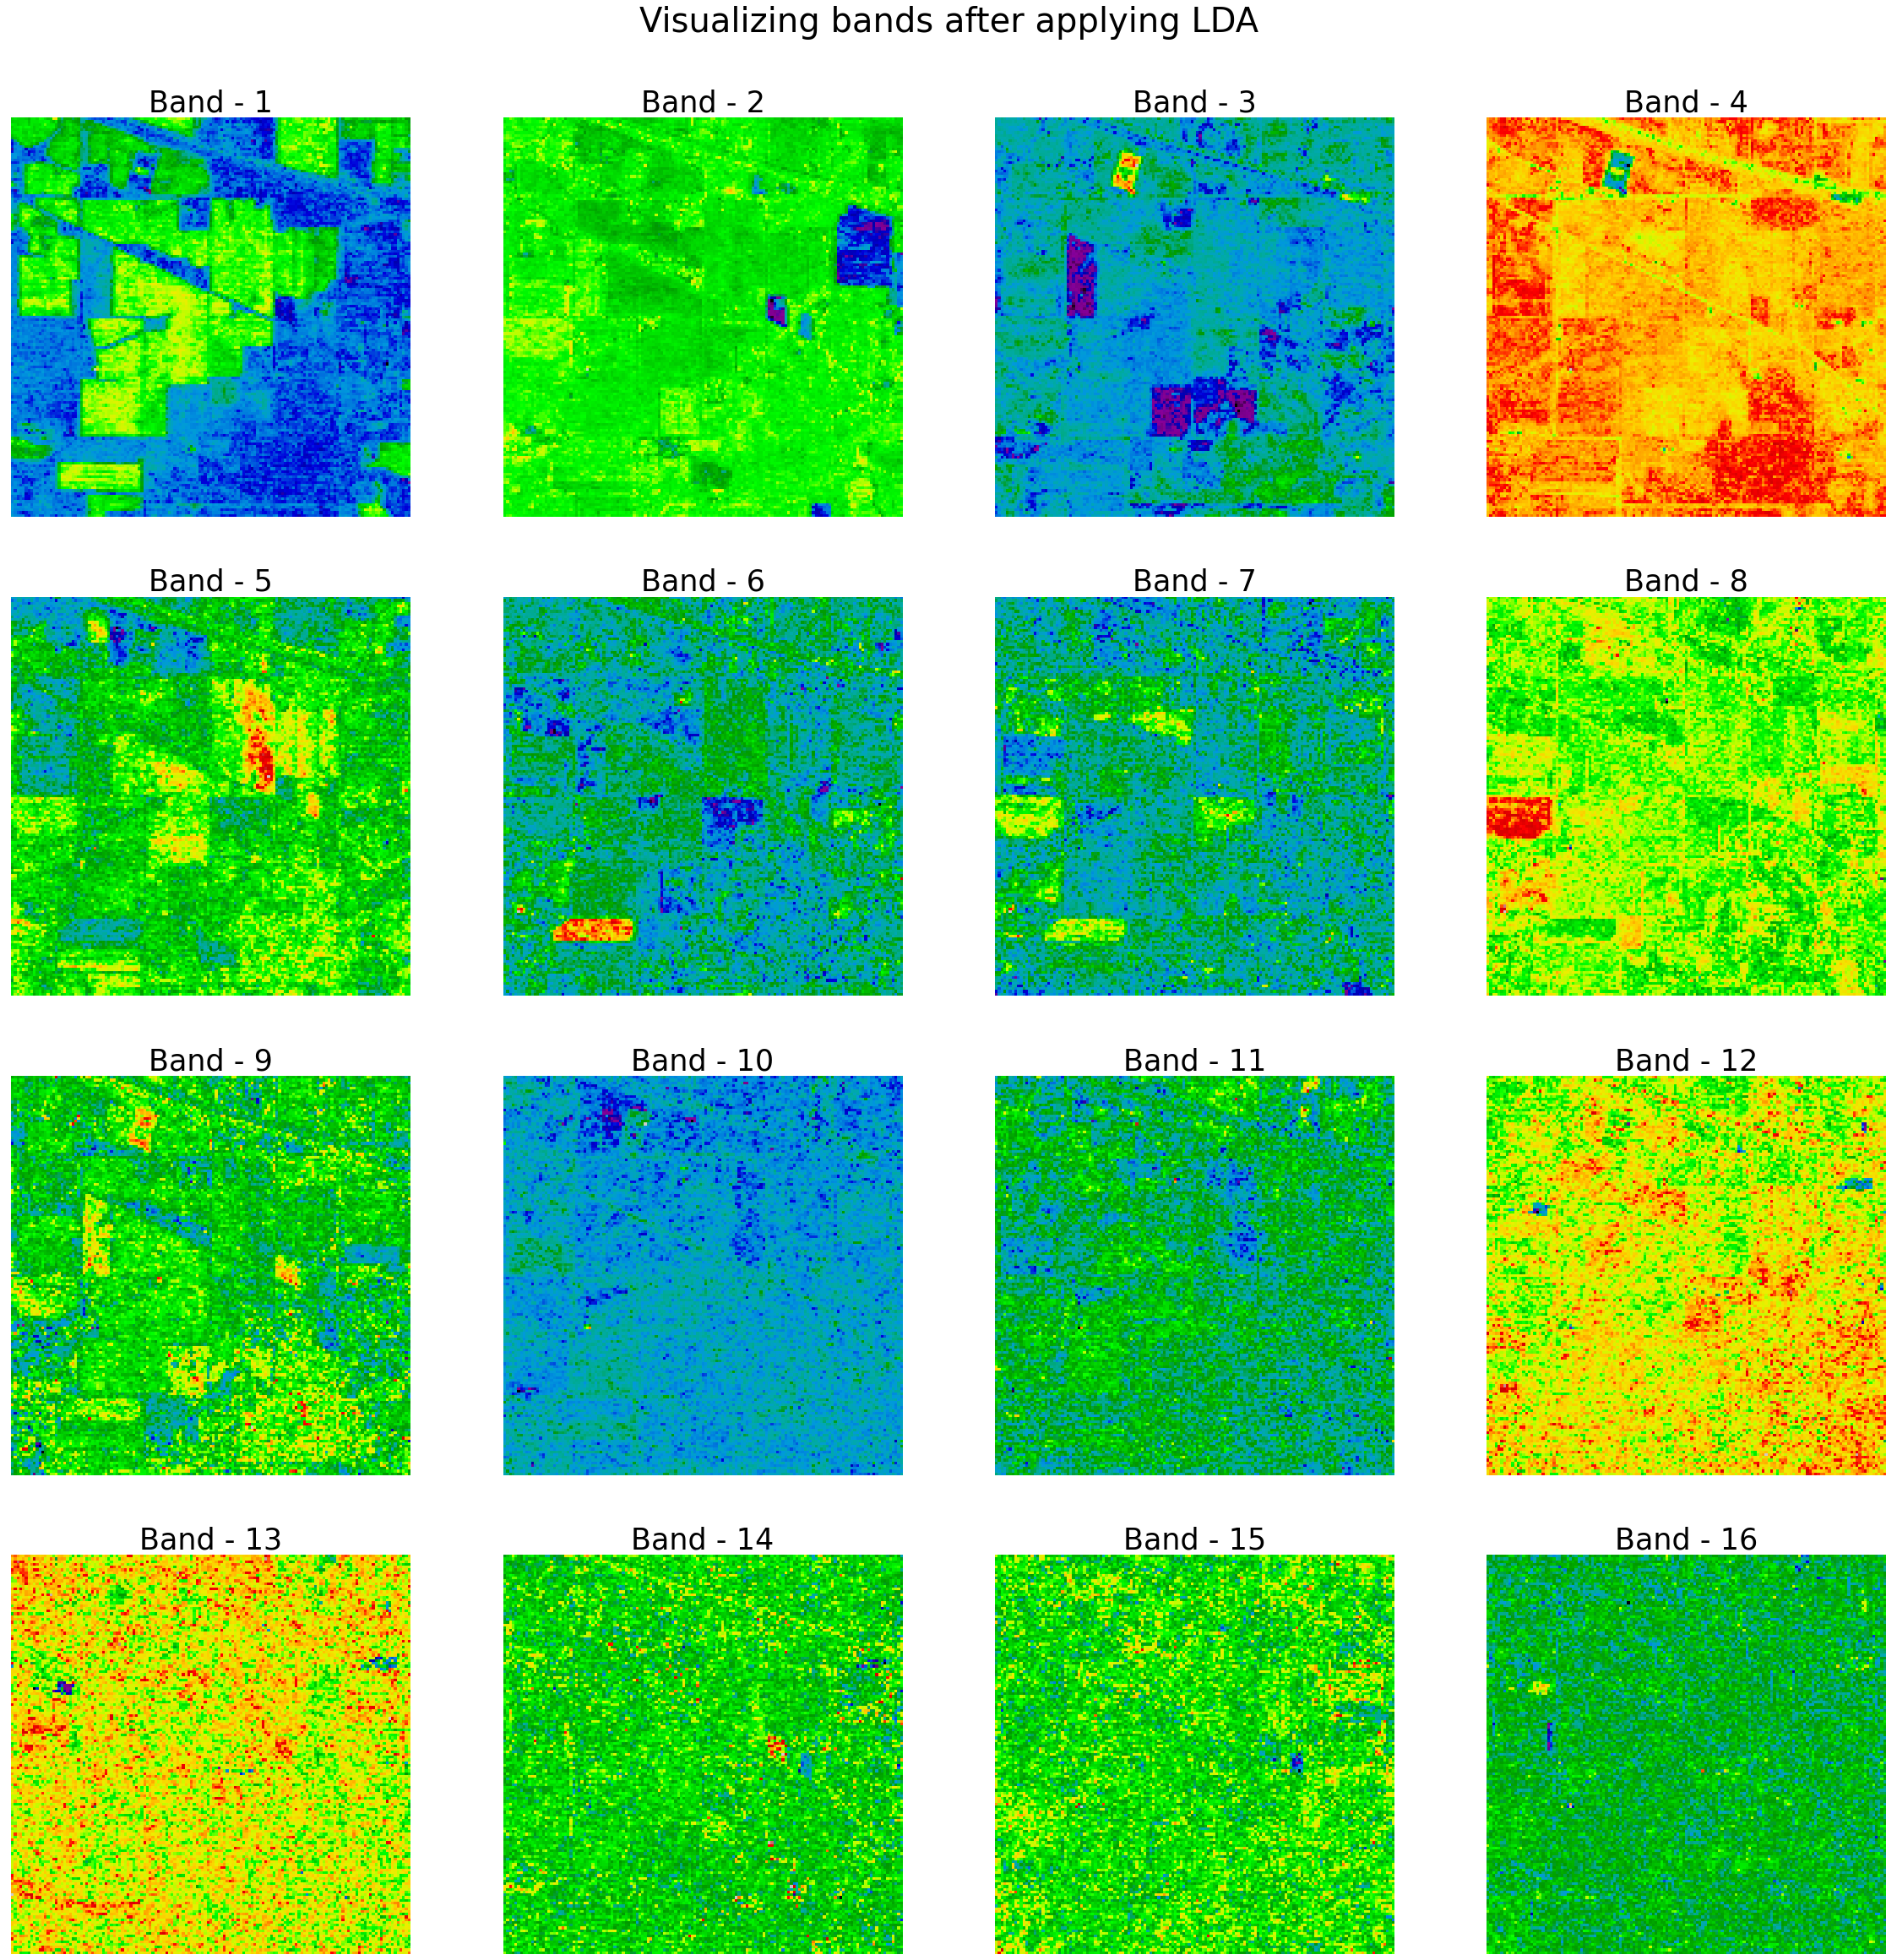

In [ ]:
fig = plt.figure(figsize = (40, 40))
fig.set_facecolor("white")
plt.title("Visualizing bands after applying LDA\n\n",fontdict={'fontsize':40})
plt.axis("off")
for i in range(1, 1+16):
    fig.add_subplot(4,4, i)
    plt.imshow(df_lda.loc[:, f'LD-{i}'].values.reshape(145, 145), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}',fontdict={'fontsize':35})